In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [39]:
hist

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2014-12-03,376.96,384.67,373.64,380.64,23504.51,8.950322e+06
2014-12-04,369.84,380.43,366.24,376.96,25331.17,9.521316e+06
2014-12-05,377.63,379.70,366.39,369.84,29989.83,1.125185e+07
2014-12-06,376.26,380.33,372.04,377.63,11072.87,4.181320e+06
2014-12-07,376.47,377.88,372.46,376.26,8811.71,3.334332e+06
...,...,...,...,...,...,...
2020-05-21,9059.11,9566.81,8811.54,9509.45,87116.97,7.982188e+08
2020-05-22,9170.74,9265.04,8936.82,9059.11,44400.90,4.052557e+08
2020-05-23,9186.19,9311.34,9101.08,9170.74,23636.66,2.178195e+08


In [0]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [0]:
train, test = train_test_split(hist, test_size=0.2)

In [0]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

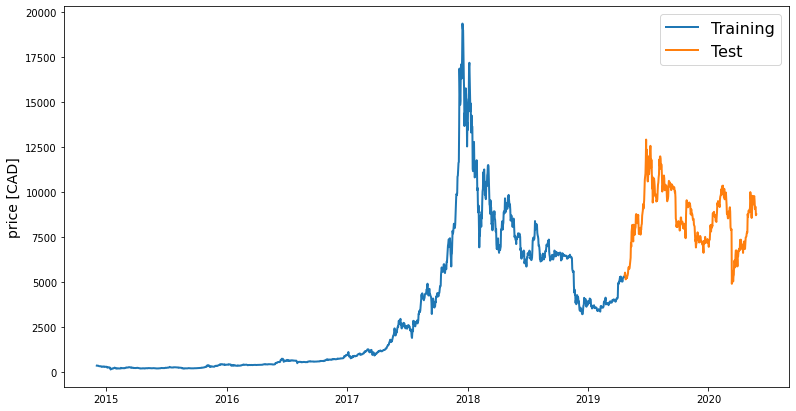

In [53]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='')

In [0]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [0]:

def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [0]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [0]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [0]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [0]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [50]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
1596/1596 [==============================] - 1s 372us/step - loss: 0.0050
Epoch 2/20
1596/1596 [==============================] - 0s 179us/step - loss: 0.0035
Epoch 3/20
1596/1596 [==============================] - 0s 185us/step - loss: 0.0030
Epoch 4/20
1596/1596 [==============================] - 0s 191us/step - loss: 0.0024
Epoch 5/20
1596/1596 [==============================] - 0s 212us/step - loss: 0.0022
Epoch 6/20
1596/1596 [==============================] - 0s 211us/step - loss: 0.0023
Epoch 7/20
1596/1596 [==============================] - 0s 196us/step - loss: 0.0021
Epoch 8/20
1596/1596 [==============================] - 0s 185us/step - loss: 0.0020
Epoch 9/20
1596/1596 [==============================] - 0s 190us/step - loss: 0.0018
Epoch 10/20
1596/1596 [==============================] - 0s 186us/step - loss: 0.0019
Epoch 11/20
1596/1596 [==============================] - 0s 183us/step - loss: 0.0019
Epoch 12/20
1596/1596 [==============================] - 0s 189

In [51]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.028985910174301795

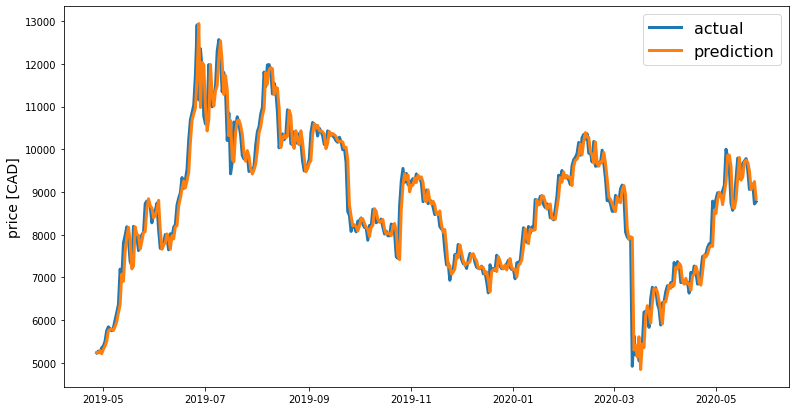

In [52]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)